In [1]:
import numpy as np
import matplotlib.pyplot as plt
from netCDF4 import Dataset
from mpl_toolkits.basemap import Basemap
from pylab import *

def read_data(filename):
    """Read NetCDF file"""
    nc_file = filename
    fh = Dataset(nc_file, mode='r')
    lons = fh.variables['lon'][:]
    lats = fh.variables['lat'][:]
    depth = fh.variables['depth'][:]
    time = fh.variables['time'][:]
    U  = fh.variables['water_u'][:]
    V  = fh.variables['water_v'][:]
    fh.close()

    lons, lats = np.meshgrid(lons, lats)
    lons -= 360.0
    
    return (time,lons,lats,depth,U,V)

In [2]:
# Specify base time of dataset and file name to read
StartDateTime = '2018-11-26 12:00:00'  # Base time of dataset from its website
time, lons, lats, depth, u, v = read_data('../data/uv20181203.nc')
u1 = u[0,0,:,:]  # get the first timestamp, top layer U
v1 = v[0,0,:,:]

# check nan indices
print(np.argwhere(np.isnan(u1)))

def nan_helper(y):
    """Helper to handle indices and logical indices of NaNs.

    Input:
        - y, 1d numpy array with possible NaNs
    Output:
        - nans, logical indices of NaNs
        - index, a function, with signature indices= index(logical_indices),
          to convert logical indices of NaNs to 'equivalent' indices
    Example:
        >>> # linear interpolation of NaNs
        >>> nans, x= nan_helper(y)
        >>> y[nans]= np.interp(x(nans), x(~nans), y[~nans])
    """
    return np.isnan(y), lambda z: z.nonzero()[0]

for i in range(u1.shape[0]):
    y = u1[i,:]
    nans, x = nan_helper(y)
    y[nans] = np.interp(x(nans), x(~nans), y[~nans])
    u1[i,:] = y

# check if nan still exists     
print(np.argwhere(np.isnan(u1)))
print(time)
print(lats.shape)
print(u1.shape)

[]
[]
[156. 159. 162. 165. 168. 171. 174. 177. 180. 183. 186.]
(15, 3)
(15, 3)


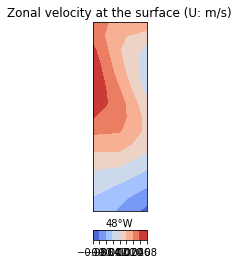

In [3]:
plt.figure()
m = Basemap(projection='cyl',llcrnrlat=lats.min(),urcrnrlat=lats.max(),
llcrnrlon=lons.min(),urcrnrlon=lons.max(),lat_ts=10,resolution='h')
x, y = m(lons,lats)
cs = m.contourf(x, y, u1, cmap='coolwarm')
m.drawparallels(np.arange(-90.,120.,1.), labels=[1,0,0,0], linewidth=0)
m.drawmeridians(np.arange(-180.,180.,1.), labels=[0,0,0,1],linewidth=0)
m.drawcoastlines()
m.colorbar(cs,location='bottom',pad='10%')
plt.title('Zonal velocity at the surface (U: m/s)')
plt.show()

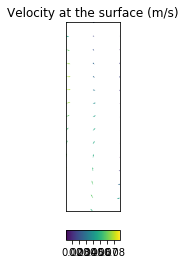

In [13]:
speed = np.sqrt(u1*u1 + v1*v1)

plt.figure()
m = Basemap(projection='cyl',llcrnrlat=lats.min(),urcrnrlat=lats.max(),
llcrnrlon=lons.min(),urcrnrlon=lons.max(),lat_ts=10,resolution='h')
x, y = m(lons,lats)
#yy = np.arange(0,y.shape[0], 1)
#xx = np.arange(0,x.shape[1], 1)
#points = np.meshgrid(yy,xx)
q = m.quiver(x,y,u1,v1,speed)#,pivot='mid',width=0.003,headwidth=3.5,headlength=5,headaxislength=4)#,cmap='viridis_r')
#m.drawparallels(np.arange(-90.,120.,1.), labels=[1,0,0,0], linewidth=0)
#m.drawmeridians(np.arange(-180.,180.,1.), labels=[0,0,0,1],linewidth=0)
#m.drawcoastlines()
m.colorbar(q,location='bottom',pad='10%')
plt.title('Velocity at the surface (m/s)')
plt.show()

In [4]:
from datetime import datetime, timedelta
from dateutil import tz
import csv

# Convert date time to local time zone
from_zone = tz.gettz('UTC')
to_zone = tz.gettz('America/Newfoundland')
start = datetime.strptime(StartDateTime, '%Y-%m-%d %H:%M:%S')
start = start.replace(tzinfo=from_zone)  # set start as UTC
#local = start.astimezone(to_zone)  # convert to local time zone
local = start.astimezone(from_zone)


#delta = timedelta(2/24.)
#datetime = datetime.strptime(StartDateTime, '%Y-%m-%d %H:%M:%S') + delta
#print(str(datetime))
print(local)

2018-11-26 12:00:00+00:00


In [5]:
# Write output file per 3-hour
for n in range(time.shape[0]):
    
    # convert time to local date time as string
    days = time[n]/24
    delta = timedelta(days)
    datetime = local + delta
    datetime = str(datetime)[0:19]
    datetime = datetime.replace('-','').replace(' ','').replace(':','')
    filename = datetime + '.LLU'
    print("Writing file: ", filename)
    
    # write array
    u0 = u[n,0,:,:]  # top layer
    v0 = v[n,0,:,:]
    
    # interpolate nan points
    for i in range(u0.shape[0]):
        y = u0[i,:]
        nans, x = nan_helper(y)
        y[nans] = np.interp(x(nans), x(~nans), y[~nans])
        u0[i,:] = y
    for i in range(u0.shape[0]):
        y = v0[i,:]
        nans, x = nan_helper(y)
        y[nans] = np.interp(x(nans), x(~nans), y[~nans])
        v0[i,:] = y
    
    data = np.zeros([u0.shape[0]*u0.shape[1],4], float64)
    ij = -1
    for i in range(u0.shape[0]):
        for j in range(u0.shape[1]):
            ij += 1
            data[ij,:] = lons[i,j], lats[i,j], u0[i,j], v0[i,j]

    # write data to file
    header = filename[2:4]+' '+filename[4:6]+' '+filename[6:8]+' '+filename[8:10]+'.00'
    np.savetxt(filename,data,delimiter=" ",fmt='%f',
               header='          1.00 = to meter/sec\n'
              +header+' = time', comments='')

Writing file:  20181203000000.LLU
Writing file:  20181203030000.LLU
Writing file:  20181203060000.LLU
Writing file:  20181203090000.LLU
Writing file:  20181203120000.LLU
Writing file:  20181203150000.LLU
Writing file:  20181203180000.LLU
Writing file:  20181203210000.LLU
Writing file:  20181204000000.LLU
Writing file:  20181204030000.LLU
Writing file:  20181204060000.LLU
